In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)컴퓨터비전/data ./

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv2D, MaxPool2D, SeparableConv2D, AvgPool2D
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization, Input, Add, GlobalAvgPool2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2

In [ ]:
df = pd.read_csv('./data/train.csv')
df

In [ ]:
df = pd.read_csv('./data/train.csv')
# df
train_x = df.values[:, 3:].reshape(-1, 28, 28).astype(np.uint8)
train_y = df.values[:, 1].astype(np.int)
train_let = df.values[:, 2]
print(train_x.shape)
print(train_y.shape)
print(train_let.shape)

(2048, 28, 28)
(2048,)
(2048,)


In [ ]:
df = pd.read_csv('./data/test.csv')
# df
test_x = df.values[:, 2:].reshape(-1, 28, 28).astype(np.uint8)
test_let = df.values[:, 1]
print(test_x.shape)
print(test_let.shape)

(20480, 28, 28)
(20480,)


In [ ]:
big_train_x = np.zeros((len(train_x), 300, 300, 1))
for i, one in enumerate(train_x):
  big_train_x[i,:,:,:] = cv2.resize(one,(300,300),interpolation = cv2.INTER_LINEAR).reshape(300,300,1)


In [ ]:
def chr2int(data):
  base = ord('A')
  data = list(map(lambda x:ord(x)-base, data))
  return np.array(data, dtype=np.int)


In [ ]:
train_let = chr2int(train_let)
train_let.shape

(2048,)

In [ ]:
def data_facto(train_x): # (-1, 28, 28, 1) # (-1,0,1)
  new1 = copy.deepcopy(train_x)
  new1[train_x == -1] = -1
  new1[train_x == 0] = 0
  new1[train_x == 1] = 1

  new2 = copy.deepcopy(train_x)
  new2[train_x == -1] = -1
  new2[train_x == 0] = 1
  new2[train_x == 1] = 0
  
  new3 = copy.deepcopy(train_x)
  new3[train_x == -1] = 1
  new3[train_x == 0] = -1
  new3[train_x == 1] = 0

  new4 = copy.deepcopy(train_x)
  new4[train_x == -1] = 1
  new4[train_x == 0] = 0
  new4[train_x == 1] = -1
  
  new5 = copy.deepcopy(train_x)
  new5[train_x == -1] = 0
  new5[train_x == 0] = 1
  new5[train_x == 1] = -1
  
  new6 = copy.deepcopy(train_x)
  new6[train_x == -1] = 0
  new6[train_x == 0] = -1
  new6[train_x == 1] = 1
  
  return np.concatenate([new1, new2, new3, new4, new5, new6], axis=-1)

In [ ]:
new_train_x = data_facto(train_x)
new_train_x.shape

(2048, 28, 28, 6)

In [ ]:
part_y.shape

(1843, 2)

In [ ]:
part_x, valid_x, part_y, valid_y = train_test_split( 
    new_train_x, train_ylet, test_size = 0.1, random_state=777)

In [ ]:
part_x, valid_x, part_y, valid_y = train_test_split( 
    big_train_x, train_y, test_size = 0.1, random_state=777)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)



In [ ]:
xcep = tf.keras.applications.Xception(weights=None, input_shape=(300,300,1), classes=10)
model = tf.keras.Sequential()
model.add(xcep)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(datagen.flow(part_x, part_y, batch_size=64), 
          validation_data = (valid_x, valid_y),
          epochs = 70
          )

In [ ]:
def lr_scheduler(epoch, lr):
  if epoch < 10 or epoch > 70:
    return lr
  else:
    return lr * 0.95

callback1 = LearningRateScheduler(lr_scheduler)

In [ ]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=(1,1), activation='elu', weight_decay=1e-5, bn = True):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=(1,1), activation='elu', weight_decay=1e-5, depth_multiplier=1, bn = True):
    x = SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

In [ ]:
model_input = Input(shape=(300, 300, 1))
x = model_input

res = conv2d_bn(x, 64, (1,1), strides=(2,2), activation=None)
x = conv2d_bn(x, 64, (3,3), activation='elu')
x = conv2d_bn(x, 64, (3,3), activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

# x = Dropout(0.3)(x)

res = conv2d_bn(x, 128, (1,1), strides=(2,2), activation=None)
x = conv2d_bn(x, 128, (3,3), activation='elu')
x = conv2d_bn(x, 128, (3,3), activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

# x = Dropout(0.3)(x)

res = conv2d_bn(x, 256, (1,1), strides=(2,2), activation=None)
x = conv2d_bn(x, 256, (3,3), activation='elu')
x = conv2d_bn(x, 256, (3,3), activation='elu')
x = conv2d_bn(x, 256, 3, activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

# x = Dropout(0.3)(x)

res = conv2d_bn(x, 512, (1,1), strides=(2,2), activation=None)
x = conv2d_bn(x, 512, (3,3), activation='elu')
x = conv2d_bn(x, 512, (3,3), activation='elu')
x = conv2d_bn(x, 512, (3,3), activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

# x = Dropout(0.3)(x)

x = GlobalAvgPool2D()(x)
# x = Flatten()(x)

model_output = Dense(10, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
model.summary()

In [ ]:
model_input = Input(shape=(28, 28, 6))
x = model_input

res = conv2d_bn(x, 32, (1,1), strides=(2,2), activation=None)
x = sepconv2d_bn(x, 32, (3,3), activation='elu')

# x = sepconv2d_bn(x, 32, (3,3), activation='elu')
# x = conv2d_bn(x, 32, (5,5), strides=(2,2), activation=None)
x = conv2d_bn(x, 32, (3,3), activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = Dropout(0.3)(x)

res = conv2d_bn(x, 64, (1,1), strides=(2,2), activation=None)
x = sepconv2d_bn(x, 64, (3,3), activation='elu')

# x = sepconv2d_bn(x, 64, (3,3), activation='elu')
# x = conv2d_bn(x, 64, (5,5), strides=(2,2), activation=None)
x = conv2d_bn(x, 64, (3,3), activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = Dropout(0.3)(x)

res = conv2d_bn(x, 128, (1,1), strides=(2,2), activation=None)
x = sepconv2d_bn(x, 128, (3,3), activation='elu')
x = sepconv2d_bn(x, 128, (3,3), activation='elu')

# x = sepconv2d_bn(x, 128, (3,3), activation='elu')
# x = conv2d_bn(x, 128, (5,5), strides=(2,2), activation=None)
x = conv2d_bn(x, 128, 3, activation=None)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = Dropout(0.3)(x)

# x = GlobalAvgPool2D()(x)
x = Flatten()(x)

model_output = Dense(10, activation="softmax", name='out1')(x)
model_output2 = Dense(26, activation='softmax', name='out2')(x)

model = Model(model_input, outputs=[model_output,model_output2] )

optimizer = SGD(lr=0.001, momentum=0.9)
model.compile('adam', loss={'out1':'sparse_categorical_crossentropy', 'out2':'sparse_categorical_crossentropy'}, metrics=['acc'])
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
# model.summary()

In [ ]:
valid_y.shape

(205, 2)

In [ ]:
history = model.fit(
    datagen.flow(part_x, part_y, batch_size=32), 
    # datagen.flow(part_x, {'out1':part_y[:,0], 'out2':part_y[:,1]}, batch_size=32), 
    # x = gen_x, 
    # y={'out1':gen_y[:,0], 'out2':gen_y[:,1]},
    # aug_train_x, to_categorical(aug_train_y, num_classes=61), 
    # aug_train_x, [aug_train_y]*4,
    # [new_train_x, to_categorical(train_let, num_classes=26)], train_y, 
    # part_x, [part_y]*n, 
    # train_x, to_categorical(train_y, num_classes=10), 
    # train_x, [train_y]*n, 
    # validation_data=(valid_x, {'out1':valid_y[:,0], 'out2':valid_y[:,1]}), 
    validation_data=(valid_x, valid_y), 
    # validation_split=0, epochs=60, batch_size=12, callbacks=[callback1], initial_epoch=30)
    validation_split=0, epochs=100, batch_size=32, initial_epoch=0)

Epoch 1/100
58/58 [==============================] - 66s 1s/step - loss: 2.3157 - acc: 0.1487 - val_loss: 2.7141 - val_acc: 0.0683
Epoch 2/100
58/58 [==============================] - 57s 977ms/step - loss: 2.2019 - acc: 0.1818 - val_loss: 2.3799 - val_acc: 0.0976
Epoch 3/100
58/58 [==============================] - 57s 980ms/step - loss: 2.1579 - acc: 0.2046 - val_loss: 2.2845 - val_acc: 0.1805
Epoch 4/100
58/58 [==============================] - 57s 980ms/step - loss: 2.1107 - acc: 0.2328 - val_loss: 2.3541 - val_acc: 0.1561
Epoch 5/100
58/58 [==============================] - 57s 982ms/step - loss: 2.0648 - acc: 0.2550 - val_loss: 2.3729 - val_acc: 0.1902
Epoch 6/100
58/58 [==============================] - 57s 981ms/step - loss: 2.0227 - acc: 0.2870 - val_loss: 3.0631 - val_acc: 0.1024
Epoch 7/100
58/58 [==============================] - 57s 978ms/step - loss: 1.9895 - acc: 0.3114 - val_loss: 2.2989 - val_acc: 0.1122
Epoch 8/100
58/58 [==============================] - 57s 981ms/st

KeyboardInterrupt: ignored

In [ ]:
def show_history(history, start=0):
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(history.history['loss'][start:], label='loss')
  ax1.plot(history.history['val_loss'][start:], label='val_loss')
  ax1.grid()
  ax1.legend()
  ax2.plot(history.history['acc'][start:], label='acc')
  ax2.plot(history.history['val_acc'][start:], label='val_acc')
  ax2.grid()
  ax2.legend()

  plt.show()

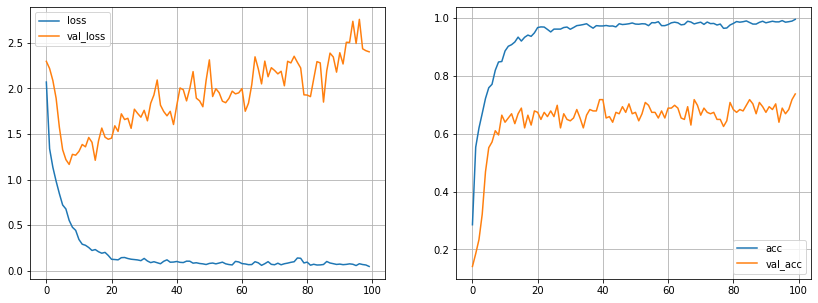

In [ ]:
show_history(history)

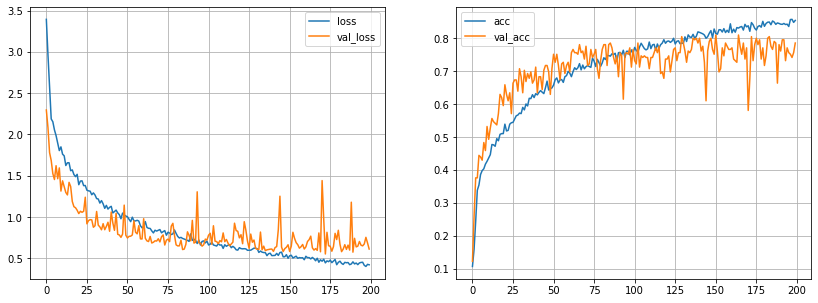

In [ ]:
show_history(history)

In [ ]:
gen_x = []
gen_y = []
gen = datagen.flow(part_x, part_y, batch_size=100)
for i in range(200):
  x, y = gen.next()
  gen_x.extend(x.tolist())
  gen_y.extend(y.tolist())

gen_x = np.array(gen_x)
gen_y = np.array(gen_y)
print(gen_x.shape)
print(gen_y.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1843, 28, 28, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


(19430, 28, 28, 6)
(19430, 2)


In [ ]:
gen_x[8,:,:,0]

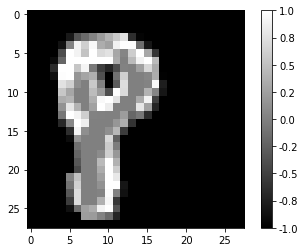

In [ ]:
plt.imshow(gen_x[1100,:,:,5], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()

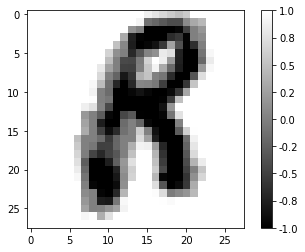

In [ ]:
plt.imshow(gen_x[8,:,:,1], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()

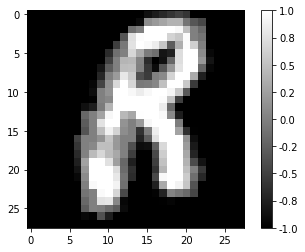

In [ ]:
plt.imshow(gen_x[8,:,:,2], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()

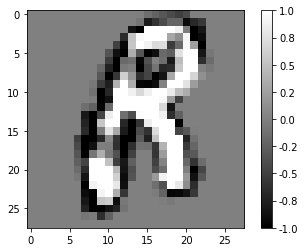

In [ ]:
plt.imshow(gen_x[8,:,:,3], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()

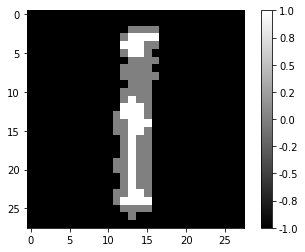

In [ ]:
plt.imshow(new_train_x[0,:,:,2], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()

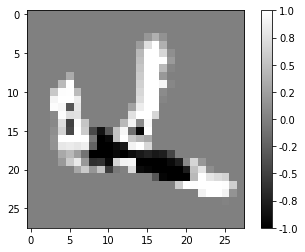

In [ ]:
plt.imshow(gen_x[14,:,:,0], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()

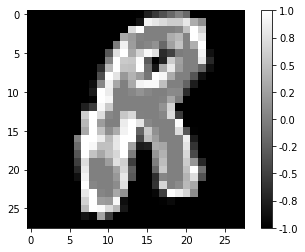

In [ ]:
plt.imshow(gen_x[8,:,:,5], cmap=plt.cm.gray)
plt.colorbar(format='%0.1f')
plt.show()